# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.4.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached joblib-1.4.0-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4019,0,62.0,14100.0,0,4
2013,1,28.0,49200.0,0,0
4061,1,36.0,45900.0,1,0
1787,0,34.0,37900.0,0,0
4648,0,27.0,45300.0,1,0
720,0,25.0,28300.0,0,0
1083,1,27.0,35000.0,1,0
2976,1,35.0,42300.0,1,0
1763,1,29.0,48100.0,2,0
3863,0,24.0,34900.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int')

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Descriptive statistics look normal for the data we are looking at. Each mean makes logical sense. I believe this data is ready to move on.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

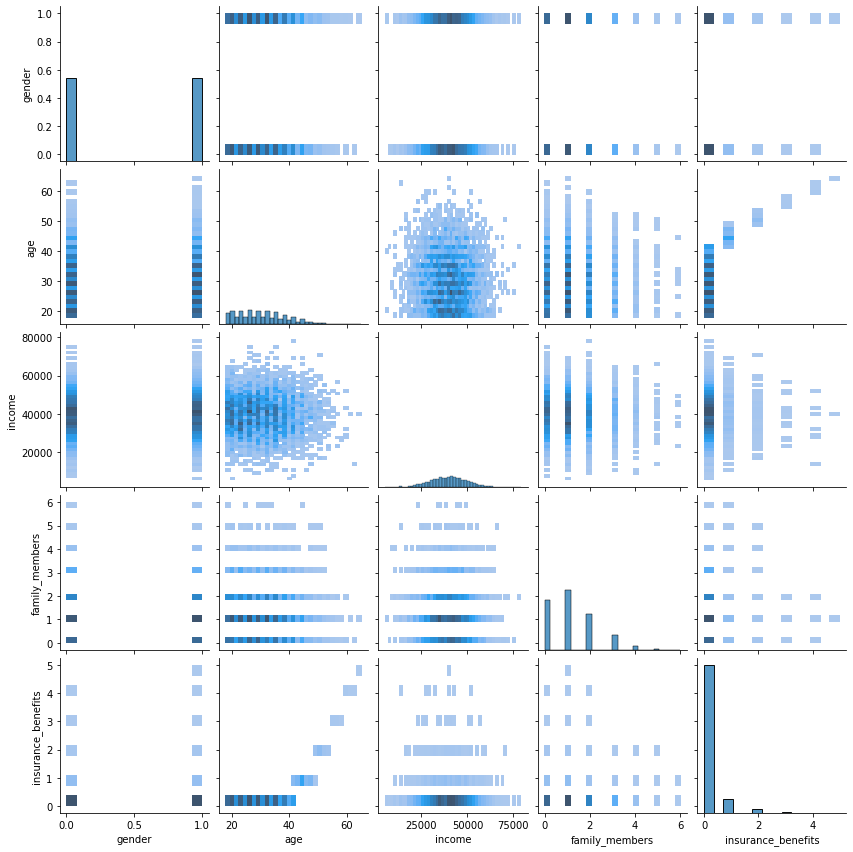

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric=metric).fit(df[feature_names].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1583,0.0,0.492308,0.639241,0.000000,0
19,1.0,0.415385,0.467089,0.000000,0
2926,1.0,0.353846,0.540506,0.000000,0
844,0.0,0.323077,0.505063,0.333333,0
4274,1.0,0.323077,0.574684,0.166667,0


Now, let's get similar records for a given one for every combination

In [15]:
%%time

# lists to store results
all_nearest_nbrs_euc = []
all_nearest_nbrs_man = []
all_nearest_nbrs_scaled_euc = []
all_nearest_nbrs_scaled_man = []

for n in range(len(df)):
    nbrs_euclidean = get_knn(df, n, k=5, metric='euclidean')
    nbrs_manhattan = get_knn(df, n, k=5, metric='manhattan')
    
    top_euclidean = nbrs_euclidean.head()
    top_manhattan = nbrs_manhattan.head()
    
    all_nearest_nbrs_euc.append(top_euclidean)
    all_nearest_nbrs_man.append(top_manhattan)

    # scaling
    nbrs_euclidean_scaled = get_knn(df_scaled, n, k=5, metric='euclidean')
    nbrs_manhattan_scaled = get_knn(df_scaled, n, k=5, metric='manhattan')

    top_euclidean_scaled = nbrs_euclidean_scaled.head()
    top_manhattan_scaled = nbrs_manhattan_scaled.head()
    
    all_nearest_nbrs_scaled_euc.append(top_euclidean_scaled)
    all_nearest_nbrs_scaled_man.append(top_manhattan_scaled)

CPU times: user 4min 36s, sys: 405 ms, total: 4min 36s
Wall time: 4min 37s


In [16]:
all_nearest_nbrs_euc

[      gender  age   income  family_members  insurance_benefits  distance
 0          1   41  49600.0               1                   0  0.000000
 2022       1   41  49600.0               0                   0  1.000000
 1225       0   42  49600.0               0                   1  1.732051
 4031       1   44  49600.0               2                   1  3.162278
 3424       0   38  49600.0               0                   0  3.316625,
       gender  age   income  family_members  insurance_benefits   distance
 1          0   46  38000.0               1                   1   0.000000
 3920       0   40  38000.0               0                   0   6.082763
 4948       1   37  38000.0               1                   0   9.055385
 2528       1   36  38000.0               0                   0  10.099505
 3593       0   33  38000.0               0                   0  13.038405,
       gender  age   income  family_members  insurance_benefits    distance
 2          0   29  21000.0 

In [17]:
all_nearest_nbrs_man

[      gender  age   income  family_members  insurance_benefits  distance
 0          1   41  49600.0               1                   0       0.0
 2022       1   41  49600.0               0                   0       1.0
 1225       0   42  49600.0               0                   1       3.0
 4031       1   44  49600.0               2                   1       4.0
 3424       0   38  49600.0               0                   0       5.0,
       gender  age   income  family_members  insurance_benefits  distance
 1          0   46  38000.0               1                   1       0.0
 3920       0   40  38000.0               0                   0       7.0
 4948       1   37  38000.0               1                   0      10.0
 2528       1   36  38000.0               0                   0      12.0
 3593       0   33  38000.0               0                   0      14.0,
       gender  age   income  family_members  insurance_benefits  distance
 2          0   29  21000.0         

In [18]:
all_nearest_nbrs_scaled_euc

[      gender       age    income  family_members  insurance_benefits  distance
 0        1.0  0.630769  0.627848        0.166667                   0  0.000000
 2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
 133      1.0  0.615385  0.636709        0.166667                   0  0.017754
 4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
 3275     1.0  0.646154  0.651899        0.166667                   1  0.028550,
       gender       age    income  family_members  insurance_benefits  distance
 1        0.0  0.707692  0.481013        0.166667                   1  0.000000
 4162     0.0  0.707692  0.477215        0.166667                   1  0.003797
 1863     0.0  0.707692  0.492405        0.166667                   1  0.011392
 4986     0.0  0.723077  0.491139        0.166667                   1  0.018418
 4477     0.0  0.692308  0.459494        0.166667                   1  0.026453,
       gender       age    income  fam

In [19]:
all_nearest_nbrs_scaled_man

[      gender       age    income  family_members  insurance_benefits  distance
 0        1.0  0.630769  0.627848        0.166667                   0  0.000000
 2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
 133      1.0  0.615385  0.636709        0.166667                   0  0.024245
 4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
 3365     1.0  0.630769  0.596203        0.166667                   0  0.031646,
       gender       age    income  family_members  insurance_benefits  distance
 1        0.0  0.707692  0.481013        0.166667                   1  0.000000
 4162     0.0  0.707692  0.477215        0.166667                   1  0.003797
 1863     0.0  0.707692  0.492405        0.166667                   1  0.011392
 4986     0.0  0.723077  0.491139        0.166667                   1  0.025511
 2434     0.0  0.676923  0.482278        0.166667                   1  0.032035,
       gender       age    income  fam

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?**\
The non-scaled data seems to be choosing the neighbors with the same (or extremely similar) income levels, where the scaled data's neighbors all seem to be quite close together in all features. So yes, it appears that the data not being scaled does affect the kNN algorithm, in what I belive is a negative way. The scaled data seems to help select better neighbors.


**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Using the Manhattan metric does affect the distance in the slightest bit, since it is the sum of all absolute values of differences between the source and destination points. Since our features are all integers, it makes sense that the Manhattan distance is also an integer, compared to the euclidean distance. 

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: True if x == 1 else False)
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'].apply(lambda x: True if x == 1 else False)

In [21]:
df.head()

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,False
1,0,46,38000.0,1,1,True
2,0,29,21000.0,0,0,False
3,0,21,41700.0,2,0,False
4,1,28,26100.0,0,0,False


In [22]:
# check for the class imbalance with value_counts()

print(df['insurance_benefits_received'].value_counts())

False    4577
True      423
Name: insurance_benefits_received, dtype: int64


We have roughly 9% True values to our False values, which makes our classes imbalanced. If our model does not score well, we can return to perform some upsampling to increase the class balance a bit and train again.

In [23]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [24]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [25]:
df['insurance_benefits_received'].sum()

423

In [26]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(P)
    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, 5000)
    print(y_pred_rnd)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

0
The probability: 0.00
[0 0 0 ... 0 0 0]
F1: 0.00
Confusion Matrix
[[0.9154 0.    ]
 [0.0846 0.    ]]

0.0846
The probability: 0.08
[0 0 0 ... 0 0 0]
F1: 0.10
Confusion Matrix
[[0.8394 0.076 ]
 [0.0758 0.0088]]

0.5
The probability: 0.50
[1 0 1 ... 0 0 1]
F1: 0.16
Confusion Matrix
[[0.4708 0.4446]
 [0.0382 0.0464]]

1
The probability: 1.00
[1 1 1 ... 1 1 1]
F1: 0.16
Confusion Matrix
[[0.     0.9154]
 [0.     0.0846]]



Now that we have our dummy classifier randomly selecting insurance benefits, we have a baseline to compare our kNN classifier model to. 

In [27]:
# splitting dataset into features/targets and train/test data

features = df[feature_names]
target = df['insurance_benefits_received']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           test_size=0.3, random_state=1)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [28]:
# creating scaled data

feature_names = ['gender', 'age', 'income', 'family_members']

transformer_knn = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())



In [29]:
# splitting the scaled dataset into features/targets and train/test data

features_scaled = df_scaled[feature_names]
target_scaled = df_scaled['insurance_benefits_received']

features_train_scaled, features_test_scaled, target_train_scaled, target_test_scaled = train_test_split(features,
                                                                                                        target,
                                                                                                        test_size=0.3,
                                                                                                        random_state=1)

features_train_scaled = transformer_knn.transform(features_train_scaled.to_numpy())
features_test_scaled = transformer_knn.transform(features_test_scaled.to_numpy())

print(features_train_scaled.shape)
print(features_test_scaled.shape)
print(target_train_scaled.shape)
print(target_test_scaled.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [30]:
# Building function to build and train KNN Classifier for k number of neighbors
def explore_knn(k, features_train, target_train, features_test, target_test):
    knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k).fit(features_train, target_train)
    predictions = knn_model.predict(features_test)
    f1 = sklearn.metrics.f1_score(target_test, predictions)
    
    print(f'F1 score of KNN model with {k} neighbors: {f1}')

In [31]:
for i in range(1, 11):
    explore_knn(i, features_train, target_train, features_test, target_test)
    

F1 score of KNN model with 1 neighbors: 0.46226415094339623
F1 score of KNN model with 2 neighbors: 0.16417910447761194
F1 score of KNN model with 3 neighbors: 0.20833333333333334
F1 score of KNN model with 4 neighbors: 0.06504065040650406
F1 score of KNN model with 5 neighbors: 0.09523809523809523
F1 score of KNN model with 6 neighbors: 0.06611570247933883
F1 score of KNN model with 7 neighbors: 0.0813008130081301
F1 score of KNN model with 8 neighbors: 0.034188034188034185
F1 score of KNN model with 9 neighbors: 0.034188034188034185
F1 score of KNN model with 10 neighbors: 0.0


In [32]:
# scaled data
for i in range(1, 11):
        explore_knn(i, features_train_scaled, target_train_scaled, features_test_scaled, target_test_scaled)

F1 score of KNN model with 1 neighbors: 0.9043478260869564
F1 score of KNN model with 2 neighbors: 0.8585365853658536
F1 score of KNN model with 3 neighbors: 0.8495575221238938
F1 score of KNN model with 4 neighbors: 0.8450704225352113
F1 score of KNN model with 5 neighbors: 0.8691983122362869
F1 score of KNN model with 6 neighbors: 0.863849765258216
F1 score of KNN model with 7 neighbors: 0.8898678414096916
F1 score of KNN model with 8 neighbors: 0.8625592417061613
F1 score of KNN model with 9 neighbors: 0.8818181818181818
F1 score of KNN model with 10 neighbors: 0.854368932038835


When looking at the unscaled data, the model that looks at just 1 neighbor has the highest ratio of precision to recall, providing us with a model that is of average effectiveness. When we compare that to the random classifier created above, we end up with a vastly improved model, vs assigning random values. 

The scaled data is vastly improved over the unscaled data, with the 1 neighbor closing in on a perfect F1 score, telling us that the scaled data makes an incredibly accurate model!

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [33]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')

    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')    

In [35]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.43


In [36]:
# scaled data

X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled,
                                                                                test_size=0.3, random_state=12345)

lr_scaled = MyLinearRegression()

lr_scaled.fit(X_train_scaled, y_train_scaled)
print(lr_scaled.weights)

y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
# print(y_test_pred_scaled.shape)
# print(y_test_scaled.shape)
eval_regressor(y_test_scaled, y_test_pred_scaled)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.43


Using the un-scaled data, the model has respectable scores, an RMSE of 0.34, and an R2 value of 0.43. That's pretty good. 

When using the scaled data, the scores are exactly the same. It seems data scaling does not have an effect on linear regression. 

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [37]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [38]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [39]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [40]:
P_inv = np.linalg.inv(P)
print(P_inv)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Loks like our random matrix $P$ is invertible! 

Can you guess the customers' ages or income after the transformation?

In [41]:
obs_matrix = X.dot(P)
print(obs_matrix)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


Definitely can't discern any kind of useful information from this matrix! 

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [42]:
orig_matrix = obs_matrix.dot(np.linalg.inv(P))
print(orig_matrix)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [43]:
print("Original Data:")
print(X[:3])
print("Transformed Data:")
print(obs_matrix[:3])
print("Recovered Data:")
print(orig_matrix[:3])

Original Data:
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]
Transformed Data:
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]
Recovered Data:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The recovered data seems to have a lot more significant figures in the data, so the values not being exactly the same could be because of rounding, since the values we are looking at are so small. 

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

*How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above?*
- They are linked by the inverse of $P$

*What would be predicted values with $w_P$?*
- If $\hat{y} = X_{val}w$ is our prediction with the original dataset, then:\
$\hat{y}_p = X_{val}PP^{-1}w$\
$\hat{y}_p = X_{val}Iw$\
$\hat{y}_p = X_{val}w$\
Then if substitute $\hat{y}$ in for its original value of $X_{val}w$ we are left with:\
$\hat{y}_p = \hat{y}$


What does that mean for the quality of linear regression if you measure it with RMSE?
- Since the weight adjusts accordingly with the obfuscated data, the quality of the linear regression's RMSE stays the same.

**Analytical proof**

$w_P = [(XP)^T XP]^{-1} (XP)^T y$\
$w_p = [P^TX^TXP]^{-1}(XP)^Ty$\
$w_p = [(P^TX^TX)P]^{-1}(XP)^Ty$\
$w_p = P^{-1}[P^TX^TX]^{-1}(XP)^Ty$\
$w_p = P^{-1}[X^TX]^{-1}[P^T]^{-1}(XP)^Ty$\
$w_p = P^{-1}[X^TX]^{-1}[P^T]^{-1}P^TX^Ty$\
$w_p = P^{-1}[X^TX]^{-1}IX^Ty$\
$w_p = P^{-1}[X^TX]^{-1}X^Ty$

And since $w = (X^T X)^{-1} X^T y$, we can therefore conclude:

$w_p = P^{-1}w$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Multiply the feature dataset by the new matrix that has been proven to be invertible.
- Use $XP$ as the new feature matrix

In [44]:
# Generating a square matrix P of random numbers
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [45]:
# checking that it is invertible
P_inv = np.linalg.inv(P)
print(P_inv)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


In [46]:
obs_data_train = features_train.dot(P)
obs_data_test = features_test.dot(P)

In [47]:
# LR model on original data

LR_orig = sklearn.linear_model.LinearRegression()
LR_orig.fit(features_train, target_train)

predictions_orig = LR_orig.predict(features_test)

eval_regressor(target_test, predictions_orig)

RMSE: 0.23
R2: 0.23


In [48]:
# LR model on obfuscated data

LR_obs = sklearn.linear_model.LinearRegression()
LR_obs.fit(obs_data_train, target_train)

predictions_obs = LR_obs.predict(obs_data_test)

eval_regressor(target_test, predictions_obs)

RMSE: 0.23
R2: 0.23


# Conclusions

Through this project, we have done the following:

- Implemented a function that takes in a dataset, and returns the n most similar customers to the customer requested
- Built and trained a KNN model using SKLearn
- Built and trained a Linear Regression Model from scratch, not using SKLearn's library functions
- Obfuscated data using a random square matrix and retrieved the original data back using the inverse of the random square matrix
- Proved analytically that data obfuscation does not interfere with linear regression
- Proved computationally that data obfuscation does not interfere with linear regression, by training and evaluating models with both original and obfuscated data, receiving the same RMSE and R2 scores for each dataset. 


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>